In [37]:
import pandas as pd
import numpy as np
import os
import larch
import caliperpy
from larch.roles import P,X
pd.set_option('display.max_columns', None)

In [38]:
# Open all files from appropriate folders
surveyFile = "C:\\projects\\Oahu\\repo_new_model\\docs\\data\\_private\\vis_survey\\output\\vis_trips.csv"
# hhFile = "C:\\projects\\Oahu\\repo_new_model\\scenarios\\base_2022\\Output\\Population\\Households.bin"
tazFile = "C:\\projects\\Oahu\\repo_new_model\\master\\tazs\\master_tazs.bin"
seFile = "C:\\projects\\Oahu\\repo_new_model\\scenarios\\base_2022\\Output\\sedata\\scenario_se.bin"
# accFile = os.path.join(path, 'TAZAccessibilities.bin')

skim_path = "C:\\projects\\Oahu\\repo_new_model\\docs\\data\\input\\skims\\"
autoSkim = skim_path + "Highway_AM.omx"
ptwalkSkim = skim_path + 'Walk_to_Bus.omx'
izMatrix = skim_path + "IntraZonal.omx"
purpose = 'HBShop'
logsum_personal = "C:\\projects\\Oahu\\repo_new_model\\docs\\data\\input\\logsums\\ls_" + purpose + "_personal_AM.omx"
logsum_business = "C:\\projects\\Oahu\\repo_new_model\\docs\\data\\input\\logsums\\ls_" + purpose + "_business_AM.omx"


In [39]:
# Import both the TAZ and Survey Files into dataframes
surveyDF = pd.read_csv(surveyFile)
dk = caliperpy.TransCAD.connect()
# surveyDF = dk.GetDataFrameFromBin(surveyFile)
# hhDF = dk.GetDataFrameFromBin(hhFile)
tazDF = dk.GetDataFrameFromBin(tazFile)
seDF = dk.GetDataFrameFromBin(seFile)
# accDF = dk.GetDataFrameFromBin(accFile)
caliperpy.TransCAD.disconnect()

Connecting to TransCAD...
Disconnected from TransCAD!


True

In [40]:
# Join se data to the TAZ file
tazDF = pd.merge(tazDF, seDF, left_on='TAZID', right_on='TAZ')
tazDF['Cluster'] = tazDF['District7']
# For the vis model, collapse clusters 1 and 3
tazDF['Cluster'] = tazDF['Cluster'].replace(3, 1)
tazDF['VisArrivalsWork'].fillna(0, inplace=True)
tazDF['VisArrivalsRec'].fillna(0, inplace=True)

In [41]:

# Add the origin cluster field, which is needed later
surveyDF = surveyDF.merge(tazDF[['TAZID', 'Cluster']], left_on='o_taz', right_on = 'TAZID')
surveyDF = surveyDF.rename(columns={'Cluster': 'o_Cluster'})

# Add sequential EstDataID to the survey table
surveyDF['EstDataID'] = np.arange(len(surveyDF)) + 1
surveyDF.head()

,SAMPN,weight,visitor_type,party,deptime,arrtime,mode,o_purp,d_purp,o_taz,d_taz,o_ptype,d_ptype,pa_flag,p_taz,a_taz,iz_flag,p_purp,a_purp,trip_purp,auto_time,auto_distance,bike_time,bike_distance,walk_time,walk_distance,bus_gen_cost,bus_fare,bus_ivtt,bus_init_wait,bus_xfer_wait,bus_init_pen_time,bus_xfer_pen_time,bus_xfer_walk_time,bus_access_walk_time,bus_egress_walk_time,bus_dwell_time,bus_total_time,bus_num_xfers,bus_iv_distance,bus_length,bus_walk_time,TAZID,o_Cluster,EstDataID
0,1000149,34.41,personal,1,9/1/2011 9:00:00,9/1/2011 10:00:00,auto,home,shop,659,400,home,other,1,659,400,0,home,shop,HBShop,22.208900,15.986400,76.924300,15.384900,369.23700,15.384900,38.78780,2.04,40.705000,2.5000,12.5,0.0,10.0,0.0,5.95639,7.54887,14.5,93.7102,2.0,16.608900,17.171600,412.1190,659,6,1
1,1000161,204.39,personal,2,9/1/2011 15:45:00,9/1/2011 16:00:00,walk,eat,home,659,637,other,home,0,637,659,0,home,eat,HBEat,2.557440,0.977263,4.886310,0.977263,23.45430,0.977263,14.19430,0.68,2.007110,2.5000,0.0,0.0,0.0,0.0,11.58000,5.95639,3.0,25.0435,0.0,0.585406,1.316090,31.5861,659,6,2
2,1000167,116.79,personal,2,9/1/2011 11:00:00,9/1/2011 11:10:00,walk,shop,home,659,672,other,home,0,672,659,0,home,shop,HBShop,1.326250,0.537498,2.687490,0.537498,12.90000,0.537498,7.43654,0.68,0.825759,2.2093,0.0,0.0,0.0,0.0,1.57743,5.95639,2.0,12.5689,0.0,0.240846,0.554756,13.3141,659,6,3
3,1000167,116.79,personal,6,9/1/2011 19:30:00,9/1/2011 19:45:00,walk,eat,home,659,672,other,home,0,672,659,0,home,eat,HBEat,1.326250,0.537498,2.687490,0.537498,12.90000,0.537498,7.43654,0.68,0.825759,2.2093,0.0,0.0,0.0,0.0,1.57743,5.95639,2.0,12.5689,0.0,0.240846,0.554756,13.3141,659,6,4
4,1000183,49.15,personal,1,9/1/2011 7:00:00,9/1/2011 10:00:00,walk,home,business,659,659,other,other,1,659,659,1,home,business,HBW,0.391693,0.177754,0.888772,0.177754,4.26611,0.177754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,659,6,5


In [42]:
# Compute auto sufficiency variables
# surveyDF['TotalVehicles'] = surveyDF['Vehicles'] + surveyDF['CommercialVehicles']
# surveyDF['Segment'] = np.where(surveyDF['TotalVehicles'] == 0, 'v0', 
#                         np.where(surveyDF['TotalVehicles'] >= surveyDF['WorkersEmployed'], 'vs', 'vi'))

In [43]:
# Create the intrazonal and business/personal indicators
surveyDF['IZ'] = surveyDF['iz_flag']
surveyDF['business_flag'] = np.select([surveyDF['visitor_type'] == "business"], [1], 0)
surveyDF['personal_flag'] = np.select([surveyDF['visitor_type'] == "personal"], [1], 0)

In [44]:
# Copy TAZ attributes and select relevant survey records.
# surveyDF = surveyDF.set_index('ID_x')
# temp = tazDF.copy()
# temp = temp.add_prefix('a_')
# surveyDF = surveyDF.merge(temp, left_on='a_taz', right_on='a_TAZID')
# temp = tazDF.copy()
# temp = temp.add_prefix('p_')
# surveyDF = surveyDF.merge(temp, left_on='p_taz', right_on='p_TAZID')
surveyDF = surveyDF.loc[~(surveyDF['o_taz'].isnull())]
surveyDF = surveyDF.loc[surveyDF['trip_purp'] == purpose]
surveyDF.head()

,SAMPN,weight,visitor_type,party,deptime,arrtime,mode,o_purp,d_purp,o_taz,d_taz,o_ptype,d_ptype,pa_flag,p_taz,a_taz,iz_flag,p_purp,a_purp,trip_purp,auto_time,auto_distance,bike_time,bike_distance,walk_time,walk_distance,bus_gen_cost,bus_fare,bus_ivtt,bus_init_wait,bus_xfer_wait,bus_init_pen_time,bus_xfer_pen_time,bus_xfer_walk_time,bus_access_walk_time,bus_egress_walk_time,bus_dwell_time,bus_total_time,bus_num_xfers,bus_iv_distance,bus_length,bus_walk_time,TAZID,o_Cluster,EstDataID,IZ,business_flag,personal_flag
0,1000149,34.41,personal,1,9/1/2011 9:00:00,9/1/2011 10:00:00,auto,home,shop,659,400,home,other,1,659,400,0,home,shop,HBShop,22.20890,15.986400,76.92430,15.384900,369.2370,15.384900,38.78780,2.04,40.705000,2.5000,12.5,0.0,10.0,0.0,5.95639,7.54887,14.5,93.7102,2.0,16.608900,17.171600,412.1190,659,6,1,0,0,1
2,1000167,116.79,personal,2,9/1/2011 11:00:00,9/1/2011 11:10:00,walk,shop,home,659,672,other,home,0,672,659,0,home,shop,HBShop,1.32625,0.537498,2.68749,0.537498,12.9000,0.537498,7.43654,0.68,0.825759,2.2093,0.0,0.0,0.0,0.0,1.57743,5.95639,2.0,12.5689,0.0,0.240846,0.554756,13.3141,659,6,3,0,0,1
19,1000274,61.44,personal,1,10/3/2011 10:00:00,10/3/2011 10:01:00,bus,home,shop,659,632,home,other,1,659,632,0,home,shop,HBShop,3.67446,1.638090,8.19045,1.638090,39.3142,1.638090,12.64310,0.68,4.178420,2.5000,0.0,0.0,0.0,0.0,5.95639,6.25013,6.0,24.8849,0.0,1.371590,1.880200,45.1247,659,6,20,0,0,1
21,1000274,61.44,personal,1,10/3/2011 20:00:00,10/3/2011 20:01:00,walk,home,shop,659,669,home,other,1,659,669,0,home,shop,HBShop,1.46387,0.611089,3.05544,0.611089,14.6661,0.611089,8.59990,0.68,0.208093,2.2093,0.0,0.0,0.0,0.0,7.05995,3.63432,0.5,13.6117,0.0,0.060694,0.506289,12.1509,659,6,22,0,0,1
38,1000354,83.41,personal,2,10/5/2011 17:00:00,10/5/2011 17:01:00,walk,shop,home,659,670,other,other,0,670,659,0,home,shop,HBShop,1.54467,0.607326,3.03663,0.607326,14.5758,0.607326,7.84684,0.68,0.606059,2.2449,0.0,0.0,0.0,0.0,3.30443,5.95639,0.5,12.6118,0.0,0.176767,0.562635,13.5032,659,6,39,0,0,1


In [45]:
# Open omx files and create initial matrix dataframes
autoSkimFile = larch.OMX(autoSkim)
ptwalkSkimFile = larch.OMX(ptwalkSkim)
# ptdriveSkimFile = larch.OMX(ptdriveSkim)
# walkSkimFile = larch.OMX(walkSkim)
# bikeSkimFile = larch.OMX(bikeSkim)

zoneIDs = autoSkimFile.TAZ[:]

taz_alt_map = {zoneIDs[i]: i for i in range(len(zoneIDs))}

# Get list of origin IDs corresponding to home zone IDs for survey respondents
surveyDF['O_TAZIndex'] = surveyDF['o_taz'].map(taz_alt_map)

In [46]:
surveyDF.head()

,SAMPN,weight,visitor_type,party,deptime,arrtime,mode,o_purp,d_purp,o_taz,d_taz,o_ptype,d_ptype,pa_flag,p_taz,a_taz,iz_flag,p_purp,a_purp,trip_purp,auto_time,auto_distance,bike_time,bike_distance,walk_time,walk_distance,bus_gen_cost,bus_fare,bus_ivtt,bus_init_wait,bus_xfer_wait,bus_init_pen_time,bus_xfer_pen_time,bus_xfer_walk_time,bus_access_walk_time,bus_egress_walk_time,bus_dwell_time,bus_total_time,bus_num_xfers,bus_iv_distance,bus_length,bus_walk_time,TAZID,o_Cluster,EstDataID,IZ,business_flag,personal_flag,O_TAZIndex
0,1000149,34.41,personal,1,9/1/2011 9:00:00,9/1/2011 10:00:00,auto,home,shop,659,400,home,other,1,659,400,0,home,shop,HBShop,22.20890,15.986400,76.92430,15.384900,369.2370,15.384900,38.78780,2.04,40.705000,2.5000,12.5,0.0,10.0,0.0,5.95639,7.54887,14.5,93.7102,2.0,16.608900,17.171600,412.1190,659,6,1,0,0,1,655
2,1000167,116.79,personal,2,9/1/2011 11:00:00,9/1/2011 11:10:00,walk,shop,home,659,672,other,home,0,672,659,0,home,shop,HBShop,1.32625,0.537498,2.68749,0.537498,12.9000,0.537498,7.43654,0.68,0.825759,2.2093,0.0,0.0,0.0,0.0,1.57743,5.95639,2.0,12.5689,0.0,0.240846,0.554756,13.3141,659,6,3,0,0,1,655
19,1000274,61.44,personal,1,10/3/2011 10:00:00,10/3/2011 10:01:00,bus,home,shop,659,632,home,other,1,659,632,0,home,shop,HBShop,3.67446,1.638090,8.19045,1.638090,39.3142,1.638090,12.64310,0.68,4.178420,2.5000,0.0,0.0,0.0,0.0,5.95639,6.25013,6.0,24.8849,0.0,1.371590,1.880200,45.1247,659,6,20,0,0,1,655
21,1000274,61.44,personal,1,10/3/2011 20:00:00,10/3/2011 20:01:00,walk,home,shop,659,669,home,other,1,659,669,0,home,shop,HBShop,1.46387,0.611089,3.05544,0.611089,14.6661,0.611089,8.59990,0.68,0.208093,2.2093,0.0,0.0,0.0,0.0,7.05995,3.63432,0.5,13.6117,0.0,0.060694,0.506289,12.1509,659,6,22,0,0,1,655
38,1000354,83.41,personal,2,10/5/2011 17:00:00,10/5/2011 17:01:00,walk,shop,home,659,670,other,other,0,670,659,0,home,shop,HBShop,1.54467,0.607326,3.03663,0.607326,14.5758,0.607326,7.84684,0.68,0.606059,2.2449,0.0,0.0,0.0,0.0,3.30443,5.95639,0.5,12.6118,0.0,0.176767,0.562635,13.5032,659,6,39,0,0,1,655


In [47]:
# Create a dataframe whose index is the same as the survey and attach the 
# appropriate matrix row corresponding to the origin IDs.
# In this case, the origIDs are the production ZONEIDs of the survey respondents
origIdxs = surveyDF['O_TAZIndex'].to_numpy()
autoTimeDF = pd.DataFrame(data = autoSkimFile['Time'][:][origIdxs, :], index = surveyDF.index, columns = autoSkimFile.TAZ)
ptwalkTimeDF = pd.DataFrame(data = ptwalkSkimFile['Total Time'][:][origIdxs, :], index = surveyDF.index, columns = ptwalkSkimFile.RCIndex)

In [48]:
autoTimeDF[autoTimeDF < 0] = 9999
ptwalkTimeDF[ptwalkTimeDF < 0] = 9999

In [49]:
# Load the mode choice logsums
LSFile_personal = larch.OMX(logsum_personal)
perLSDF = pd.DataFrame(data = LSFile_personal['ROOT'][:][origIdxs, :], index = surveyDF.index, columns = LSFile_personal.TAZ)
LSFile_business = larch.OMX(logsum_business)
busLSDF = pd.DataFrame(data = LSFile_business['ROOT'][:][origIdxs, :], index = surveyDF.index, columns = LSFile_personal.TAZ)

In [50]:
# IZ Matrix
izM = larch.OMX(izMatrix)
izDF = pd.DataFrame(data = izM['IZ'][:][origIdxs, :], index = surveyDF.index, columns = izM.TAZ )

In [51]:
# Stack the data to convert to the Case Alternative (CA format).
estData_ca = pd.concat( [autoTimeDF.stack().rename("Time"), 
                         ptwalkTimeDF.stack().rename("Total Time"),
                         perLSDF.stack().rename("per_LS"),
                         busLSDF.stack().rename("bus_LS"),
                         izDF.stack().rename("IZ")], axis=1)

In [52]:
estData_ca.head()

Time   Total Time    per_LS    bus_LS  IZ
0 1  48.522976  9999.000000  0.714214  0.714214   0
  2  38.317875   146.387817  1.208578  1.208578   0
  3  70.308144  9999.000000  0.169585  0.169585   0
  4  37.185673   128.181519  1.428026  1.428026   0
  5  35.171989   129.766846  1.411281  1.411281   0

In [53]:
index_names = ['EstDataID', 'Destination']
estData_ca.index.names = index_names
estData_ca.head()


Time   Total Time    per_LS    bus_LS  IZ
EstDataID Destination                                                
0         1            48.522976  9999.000000  0.714214  0.714214   0
          2            38.317875   146.387817  1.208578  1.208578   0
          3            70.308144  9999.000000  0.169585  0.169585   0
          4            37.185673   128.181519  1.428026  1.428026   0
          5            35.171989   129.766846  1.411281  1.411281   0

In [54]:
# Attach se data to the CA/matrix data. The Destination column in the CA data
# matches up with the 'TAZID' field in the taz/se data frame.
taz_columns = [
    'Cluster',
    'Emp_Agriculture',
    'Emp_Manufacturing',
    'Emp_Wholesale',
    'Emp_Retail',
    'Emp_TransportConstruction',
    'Emp_FinanceRealEstate',
    'Emp_Education',
    'Emp_HealthCare',
    'Emp_Services',
    'Emp_Public',
    'Emp_Hotel',
    'Emp_Military',
    'VisArrivalsWork',
    'VisArrivalsRec'
]
tazDF.set_index('TAZID', inplace=True)
estData_ca = estData_ca.join(tazDF[taz_columns], on = 'Destination')
estData_ca = estData_ca.rename(columns={'Cluster': 'd_Cluster'})
estData_ca.loc[estData_ca['VisArrivalsRec'] > 0].head()

Time   Total Time    per_LS    bus_LS  IZ  \
EstDataID Destination                                                   
0         31            5.294553    35.247700  2.719573  2.719573   0   
          33            6.684790    43.436836  2.293626  2.293626   0   
          83           45.653755  9999.000000  0.785945  0.785945   0   
          251          17.381758    65.649017  1.833415  1.833415   0   
          270          20.090618   104.450714  1.513853  1.513853   0   

                       d_Cluster  Emp_Agriculture  Emp_Manufacturing  \
EstDataID Destination                                                  
0         31                   6              0.0                7.0   
          33                   5              0.0                0.0   
          83                   1              0.0                0.0   
          251                  4              0.0                9.0   
          270                  4              0.0                0.0   

                       Emp_Wholesale  Emp_Retail  Emp_TransportConstruction  \
EstDataID Destination                                                         
0         31                     4.0        11.0                       15.0   
          33                     0.0         0.0                        0.0   
          83                     0.0         0.0                        0.0   
          251                    0.0         2.0                       60.0   
          270                    0.0         0.0                        6.0   

                       Emp_FinanceRealEstate  Emp_Education  Emp_HealthCare  \
EstDataID Destination                                                         
0         31                            80.0            2.0             9.0   
          33                             2.0            0.0             0.0   
          83                             0.0            0.0             0.0   
          251                            0.0            0.0             0.0   
          270                           10.0            0.0            15.0   

                       Emp_Services  Emp_Public  Emp_Hotel  Emp_Military  \
EstDataID Destination                                                      
0         31                  276.0        11.0       35.0           0.0   
          33                    7.0         0.0        0.0           0.0   
          83                    0.0         0.0        0.0           0.0   
          251                  97.0         0.0        0.0           0.0   
          270                 367.0         6.0       17.0          50.0   

                       VisArrivalsWork  VisArrivalsRec  
EstDataID Destination                                   
0         31                       0.0           636.0  
          33                       0.0           672.0  
          83                       0.0          1414.0  
          251                      0.0           371.0  
          270                      0.0           371.0

In [55]:
# Merge relevant co columns from surveyDF into estData_ca 
cols = ["EstDataID", "visitor_type", "o_Cluster"]
estData_ca = estData_ca.join(surveyDF[cols], on='EstDataID')
# estData_ca = estData_ca.set_index(index_names)
estData_ca.head()

Time   Total Time    per_LS    bus_LS  IZ  \
EstDataID Destination                                                   
0         1            48.522976  9999.000000  0.714214  0.714214   0   
          2            38.317875   146.387817  1.208578  1.208578   0   
          3            70.308144  9999.000000  0.169585  0.169585   0   
          4            37.185673   128.181519  1.428026  1.428026   0   
          5            35.171989   129.766846  1.411281  1.411281   0   

                       d_Cluster  Emp_Agriculture  Emp_Manufacturing  \
EstDataID Destination                                                  
0         1                    1              7.0                0.0   
          2                    1              0.0                0.0   
          3                    1              0.0                0.0   
          4                    1              0.0                0.0   
          5                    1              0.0                0.0   

                       Emp_Wholesale  Emp_Retail  Emp_TransportConstruction  \
EstDataID Destination                                                         
0         1                      0.0         0.0                        0.0   
          2                      0.0         0.0                        0.0   
          3                      0.0         0.0                        9.0   
          4                      0.0         0.0                        0.0   
          5                      0.0         0.0                        2.0   

                       Emp_FinanceRealEstate  Emp_Education  Emp_HealthCare  \
EstDataID Destination                                                         
0         1                              3.0            0.0             0.0   
          2                              0.0            0.0             0.0   
          3                              0.0            0.0             0.0   
          4                              0.0            0.0             0.0   
          5                              0.0            0.0             0.0   

                       Emp_Services  Emp_Public  Emp_Hotel  Emp_Military  \
EstDataID Destination                                                      
0         1                     0.0         0.0       35.0          43.0   
          2                     0.0         0.0        0.0           0.0   
          3                     0.0         0.0        0.0           0.0   
          4                     0.0         0.0        5.0          36.0   
          5                     0.0         0.0        0.0         223.0   

                       VisArrivalsWork  VisArrivalsRec  EstDataID  \
EstDataID Destination                                               
0         1                        0.0             0.0          1   
          2                        0.0             0.0          1   
          3                        0.0             0.0          1   
          4                        0.0             0.0          1   
          5                        0.0             0.0          1   

                      visitor_type  o_Cluster  
EstDataID Destination                          
0         1               personal          6  
          2               personal          6  
          3               personal          6  
          4               personal          6  
          5               personal          6

In [56]:
# Set Availability based on size variable

estData_ca['TotalEmp'] = estData_ca['Emp_Agriculture']
+ estData_ca['Emp_Manufacturing']
+ estData_ca['Emp_Wholesale']
+ estData_ca['Emp_Retail']
+ estData_ca['Emp_TransportConstruction']
+ estData_ca['Emp_FinanceRealEstate']
+ estData_ca['Emp_Education']
+ estData_ca['Emp_HealthCare']
+ estData_ca['Emp_Services']
+ estData_ca['Emp_Public']
+ estData_ca['Emp_Hotel']
+ estData_ca['Emp_Military']
estData_ca['TotalStuff'] = estData_ca['TotalEmp']
+ estData_ca['VisArrivalsWork']
+ estData_ca['VisArrivalsRec']

estData_ca['Avail'] = estData_ca['TotalStuff'].apply(lambda x: 1 if x > 0.0 else 0)
estData_ca['one'] = 1

In [57]:
# SetUp and Run cluster DC model
dfs = larch.DataFrames(
    co=surveyDF,
    ca=estData_ca,
    alt_codes=autoSkimFile.TAZ,
    alt_names=['TAZ' + str(i) for i in autoSkimFile.TAZ],
    ch_name='a_taz',
    # av=estData_ca.Avail
    av=1
)
dfs.info(1)

# Create Larch Model
m = larch.Model(dataservice=dfs)

## Define Title
m.title = "Oahu DC " + purpose + " (NL)"

m.choice_co_code = 'd_taz'

larch.DataFrames:  (not computation-ready)
  n_cases: 458
  n_alts: 1117
  data_ca:
    - Time                      (511586 non-null float32)
    - Total Time                (511586 non-null float32)
    - per_LS                    (511586 non-null float32)
    - bus_LS                    (511586 non-null float32)
    - IZ                        (511586 non-null int16)
    - d_Cluster                 (511586 non-null Int32)
    - Emp_Agriculture           (511586 non-null float64)
    - Emp_Manufacturing         (511586 non-null float64)
    - Emp_Wholesale             (511586 non-null float64)
    - Emp_Retail                (511586 non-null float64)
    - Emp_TransportConstruction (511586 non-null float64)
    - Emp_FinanceRealEstate     (511586 non-null float64)
    - Emp_Education             (511586 non-null float64)
    - Emp_HealthCare            (511586 non-null float64)
    - Emp_Services              (511586 non-null float64)
    - Emp_Public                (511586 non-null f

In [58]:
# Get array of destinations zone IDs belonging to each cluster
c1_zones = tazDF.loc[tazDF['Cluster'] == 1].index.values
c2_zones = tazDF.loc[tazDF['Cluster'] == 2].index.values
# c3_zones = tazDF.loc[tazDF['Cluster'] == 3].index.values
c4_zones = tazDF.loc[tazDF['Cluster'] == 4].index.values
c5_zones = tazDF.loc[tazDF['Cluster'] == 5].index.values
c6_zones = tazDF.loc[tazDF['Cluster'] == 6].index.values
c7_zones = tazDF.loc[tazDF['Cluster'] == 7].index.values

In [59]:
# Define Nesting Structure based on Cluster.
c1 = m.graph.new_node(parameter='Mu:c1', children=c1_zones, name='c1')
c2 = m.graph.new_node(parameter='Mu:c2', children=c2_zones, name='c2')
# c3 = m.graph.new_node(parameter='Mu:c3', children=c3_zones, name='c3')
c4 = m.graph.new_node(parameter='Mu:c4', children=c4_zones, name='c4')
c5 = m.graph.new_node(parameter='Mu:c5', children=c5_zones, name='c5')
c6 = m.graph.new_node(parameter='Mu:c6', children=c6_zones, name='c6')
c7 = m.graph.new_node(parameter='Mu:c7', children=c7_zones, name='c7')


In [60]:
surveyDF.head()

,SAMPN,weight,visitor_type,party,deptime,arrtime,mode,o_purp,d_purp,o_taz,d_taz,o_ptype,d_ptype,pa_flag,p_taz,a_taz,iz_flag,p_purp,a_purp,trip_purp,auto_time,auto_distance,bike_time,bike_distance,walk_time,walk_distance,bus_gen_cost,bus_fare,bus_ivtt,bus_init_wait,bus_xfer_wait,bus_init_pen_time,bus_xfer_pen_time,bus_xfer_walk_time,bus_access_walk_time,bus_egress_walk_time,bus_dwell_time,bus_total_time,bus_num_xfers,bus_iv_distance,bus_length,bus_walk_time,TAZID,o_Cluster,EstDataID,IZ,business_flag,personal_flag,O_TAZIndex
0,1000149,34.41,personal,1,9/1/2011 9:00:00,9/1/2011 10:00:00,auto,home,shop,659,400,home,other,1,659,400,0,home,shop,HBShop,22.20890,15.986400,76.92430,15.384900,369.2370,15.384900,38.78780,2.04,40.705000,2.5000,12.5,0.0,10.0,0.0,5.95639,7.54887,14.5,93.7102,2.0,16.608900,17.171600,412.1190,659,6,1,0,0,1,655
2,1000167,116.79,personal,2,9/1/2011 11:00:00,9/1/2011 11:10:00,walk,shop,home,659,672,other,home,0,672,659,0,home,shop,HBShop,1.32625,0.537498,2.68749,0.537498,12.9000,0.537498,7.43654,0.68,0.825759,2.2093,0.0,0.0,0.0,0.0,1.57743,5.95639,2.0,12.5689,0.0,0.240846,0.554756,13.3141,659,6,3,0,0,1,655
19,1000274,61.44,personal,1,10/3/2011 10:00:00,10/3/2011 10:01:00,bus,home,shop,659,632,home,other,1,659,632,0,home,shop,HBShop,3.67446,1.638090,8.19045,1.638090,39.3142,1.638090,12.64310,0.68,4.178420,2.5000,0.0,0.0,0.0,0.0,5.95639,6.25013,6.0,24.8849,0.0,1.371590,1.880200,45.1247,659,6,20,0,0,1,655
21,1000274,61.44,personal,1,10/3/2011 20:00:00,10/3/2011 20:01:00,walk,home,shop,659,669,home,other,1,659,669,0,home,shop,HBShop,1.46387,0.611089,3.05544,0.611089,14.6661,0.611089,8.59990,0.68,0.208093,2.2093,0.0,0.0,0.0,0.0,7.05995,3.63432,0.5,13.6117,0.0,0.060694,0.506289,12.1509,659,6,22,0,0,1,655
38,1000354,83.41,personal,2,10/5/2011 17:00:00,10/5/2011 17:01:00,walk,shop,home,659,670,other,other,0,670,659,0,home,shop,HBShop,1.54467,0.607326,3.03663,0.607326,14.5758,0.607326,7.84684,0.68,0.606059,2.2449,0.0,0.0,0.0,0.0,3.30443,5.95639,0.5,12.6118,0.0,0.176767,0.562635,13.5032,659,6,39,0,0,1,655


In [61]:
estData_ca.describe()

,Time,Total Time,per_LS,bus_LS,IZ,d_Cluster,Emp_Agriculture,Emp_Manufacturing,Emp_Wholesale,Emp_Retail,Emp_TransportConstruction,Emp_FinanceRealEstate,Emp_Education,Emp_HealthCare,Emp_Services,Emp_Public,Emp_Hotel,Emp_Military,VisArrivalsWork,VisArrivalsRec,EstDataID,o_Cluster,TotalEmp,TotalStuff,Avail,one
count,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.000000,511586.0
mean,21.478655,631.091431,1.890606,1.890606,0.000895,3.844226,0.728738,13.851388,11.295434,46.943599,45.249776,72.334825,16.532677,46.162936,63.984781,21.371531,17.785139,33.171889,17.403760,14.813787,2119.635371,5.318777,0.728738,0.728738,0.102059,1.0
std,13.968196,2268.628418,0.706172,0.706172,0.029907,2.104458,3.836969,156.123607,51.123442,197.425744,215.892441,379.324557,63.610377,218.028211,169.983589,148.898911,212.797859,257.255509,581.400779,197.149335,1140.650752,1.380985,3.836969,3.836969,0.302726,0.0
min,0.080964,6.521756,-0.579770,-0.579770,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0
25%,9.672070,54.733681,1.466741,1.466741,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1330.000000,5.000000,0.000000,0.000000,0.000000,1.0
50%,20.459841,84.096592,1.815856,1.815856,0.000000,4.000000,0.000000,0.000000,0.000000,3.000000,7.000000,9.000000,0.000000,3.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2065.500000,6.000000,0.000000,0.000000,0.000000,1.0
75%,29.130379,110.265717,2.256702,2.256702,0.000000,5.000000,0.000000,2.000000,2.000000,17.000000,19.000000,30.000000,8.000000,21.000000,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2976.000000,6.000000,0.000000,0.000000,0.000000,1.0
max,100.282341,9999.000000,5.286416,5.286416,1.000000,7.000000,60.000000,5044.000000,581.000000,4533.000000,5629.000000,10399.000000,1523.000000,4262.000000,3568.000000,3192.000000,5239.000000,5115.000000,19440.000000,5942.000000,4374.000000,7.000000,60.000000,60.000000,1.000000,1.0


In [62]:
m.utility_ca = (
    + P.B_Time * X.Time 
    # + P.B_WalkIndex * X.WalkIndex
    # + P.B_TransitStopDensity * X.TransitStopDensity
    # + P.B_EmpAccess * X.access_employment_sov
    # + P.B_WalkAccess * X.NonMotorizedAccessibility
    # + P.B_TransitAccessJobs * X.TransitAccessibilityToJobsAM
    
    # Logsums
    # +P.LS_per * X('visitor_type == "personal"') * X.per_LS
    # +P.LS_bus * X('visitor_type == "business"') * X.bus_LS

    
    # + X('TotalEmpDensity/1000') * P.B_TotEmpDensity
    
    # Intra-zonal dummy
    # + P.B_IZ * X.IZ
    
    # Intra-cluster dummies
    # + P.B_IC * X('d_Cluster == o_Cluster')

    # Cluster ASCs
    # + P.ASC_c1 * X('o_Cluster == 1')
    # + P.ASC_c2 * X('o_Cluster == 2')
    # # + P.ASC_c3 * X('o_Cluster == 3')
    # + P.ASC_c4 * X('o_Cluster == 4')
    # + P.ASC_c5 * X('o_Cluster == 5')
    # + P.ASC_c6 * X('o_Cluster == 6')
    # + P.ASC_c7 * X('o_Cluster == 7')
)

In [63]:
m.quantity_ca = (
        # + P.TotalEmp * X('TotalEmp')
        # + P.EmpAgriculture * X('Emp_Agriculture')
        # + P.EmpManufacturing * X('Emp_Manufacturing')
        # + P.EmpWholesale * X('Emp_Wholesale')
        + P.EmpRetail * X('Emp_Retail')
        # + P.EmpTransportConstruction * X('Emp_TransportConstruction')
        # + P.EmpFinanceRealEstate * X('Emp_FinanceRealEstate')
        # + P.EmpEducation * X('Emp_Education')
        # + P.EmpHealthcare * X('Emp_HealthCare')
        + P.EmpServices * X('Emp_Services')
        # + P.EmpPublic * X('Emp_Public')
        # + P.EmpHotel * X('Emp_Hotel')
        # + P.EmpMilitary * X('Emp_Military')
        # + P.ArrivalsRec * X('VisArrivalsRec')
        # + P.ArrivalsWork * X('VisArrivalsWork')
        + P.Dummy * X.one
        + P.EmpOther * X('Emp_Agriculture')
        * X('Emp_Manufacturing')
         * X('Emp_Wholesale')
        #  * X('Emp_Retail')
         * X('Emp_TransportConstruction')
         * X('Emp_FinanceRealEstate')
         * X('Emp_Education')
         * X('Emp_HealthCare')
        #  * X('Emp_Services')
         * X('Emp_Public')
         * X('Emp_Hotel')
        #  * X('Emp_Military')
)

m.quantity_scale = P.Size

m.lock_values(Dummy = 0.0)

In [64]:
m.utility_functions()

+ P.B_Time * X.Time + P.Size * log( + exp(P.EmpRetail) * X.Emp_Retail + exp(P.EmpServices) * X.Emp_Services + exp(P.Dummy) * X.one + exp(P.EmpOther) * X('(((((((Emp_Agriculture*Emp_Manufacturing)*Emp_Wholesale)*Emp_TransportConstruction)*Emp_FinanceRealEstate)*Emp_Education)*Emp_HealthCare)*Emp_Public)*Emp_Hotel'))


In [65]:
#m.weight_co_var = 'hh_weight_combined'
m.load_data()

req_data does not request avail_ca or avail_co but it is set and being provided
converting data_ca to <class 'numpy.float64'>


In [66]:
m.dataframes.choice_avail_summary()

,name,chosen,available
1,TAZ1,0.0,458.0
2,TAZ2,0.0,458.0
3,TAZ3,0.0,458.0
4,TAZ4,0.0,458.0
5,TAZ5,0.0,458.0
...,...,...,...
1117,TAZ1117,0.0,458.0
1118,TAZ1118,0.0,458.0
1119,TAZ1119,0.0,458.0
1120,TAZ1120,0.0,458.0


In [67]:
# Run MLE
m.maximize_loglike(method='SLSQP')

# Order output parameters
m.ordering = [
        ("ASCs", 'ASC.*',),
        ("Size", 'Size.*',),
        ("Logsums", 'LS.*',),
        ("Betas", 'B_.*',),
        # ("Accessibilities", 'Acc.*',),
        # ("HomeClusters", 'HomeCluster_.*',),
        ("NestCoeffs", 'Mu.*',),
        ("Attractions", 'Attr.*',),
]

# Calculate Stats
m.calculate_parameter_covariance()

,value,initvalue,nullvalue,minimum,maximum,holdfast,note,best
B_Time,-0.101851,0.0,0.0,-inf,inf,0,,-0.101851
Dummy,0.000000,0.0,0.0,0.000,0.0,1,,0.000000
EmpOther,-62.573716,0.0,0.0,-inf,inf,0,,-62.573716
EmpRetail,-4.607088,0.0,0.0,-inf,inf,0,,-4.607088
EmpServices,-4.474295,0.0,0.0,-inf,inf,0,,-4.474295
Mu:c1,0.683839,1.0,1.0,0.001,1.0,0,,0.683839
Mu:c2,0.713134,1.0,1.0,0.001,1.0,0,,0.713134
Mu:c4,0.478116,1.0,1.0,0.001,1.0,0,,0.478116
Mu:c5,0.441732,1.0,1.0,0.001,1.0,0,,0.441732
Mu:c6,1.000000,1.0,1.0,0.001,1.0,0,,1.000000


c:\Users\Kyle\mambaforge\envs\myenv\lib\site-packages\larch\model\optimization.py:308: UserWarning: SLSQP may not play nicely with unbounded parameters
if you get poor results, consider setting global bounds with model.set_cap()
  warnings.warn( # infinite bounds # )
C:\Users\Kyle\AppData\Local\Temp\ipykernel_50136\3368381925.py:17: PossibleOverspecification: WARNING: Model is possibly over-specified (hessian is nearly singular).
  m.calculate_parameter_covariance()
c:\Users\Kyle\mambaforge\envs\myenv\lib\site-packages\larch\linalg\__init__.py:18: UserWarning: minimum eig 2.2488732202605526e-10 in general_inverse
  warnings.warn(f"minimum eig {min_eig} in general_inverse")


In [68]:
m.utility_functions()

+ P.B_Time * X.Time + P.Size * log( + exp(P.EmpRetail) * X.Emp_Retail + exp(P.EmpServices) * X.Emp_Services + exp(P.Dummy) * X.one + exp(P.EmpOther) * X('(((((((Emp_Agriculture*Emp_Manufacturing)*Emp_Wholesale)*Emp_TransportConstruction)*Emp_FinanceRealEstate)*Emp_Education)*Emp_HealthCare)*Emp_Public)*Emp_Hotel'))


In [69]:
m.parameter_summary()

In [70]:
m.estimation_statistics()

<xmle.Elem 'div' with 1 children>

<Axes: xlabel='Time', ylabel='Relative Frequency'>

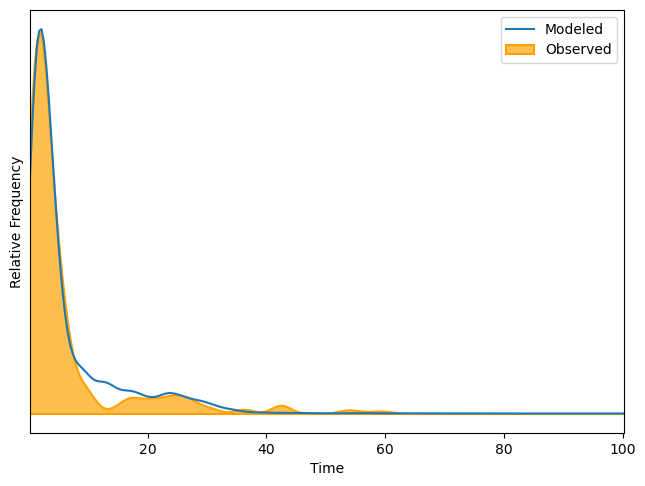

In [71]:
m.distribution_on_idca_variable('Time', style='kde',)

<Axes: xlabel='Time', ylabel='Relative Frequency'>

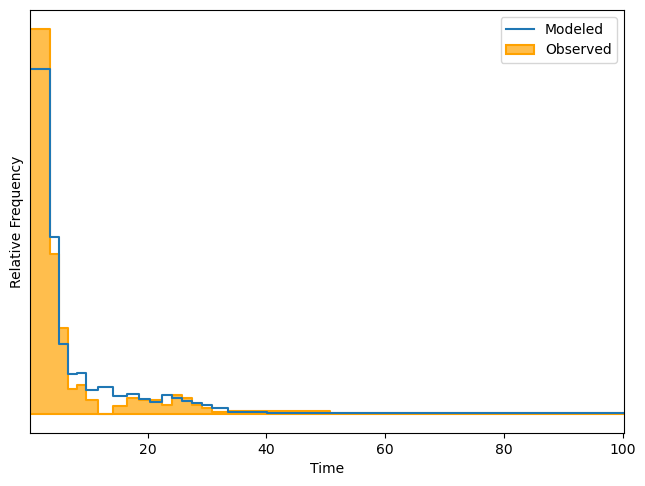

In [72]:
m.distribution_on_idca_variable('Time')

In [73]:
# Report
report = larch.Reporter(title=m.title)
report << '## Data Statistics' << m.dataframes.data_ca.statistics()
report << "## Utility Functions" << m.utility_functions()
report << '## Parameter Summary' << m.parameter_summary()
report << "## Estimation Statistics" << m.estimation_statistics()

# Add figure
#report << "## Visualization"
#report << fig

report.save(
    '.\Oahu_VisDC_' + purpose + '_NL.html',
    overwrite=True,
    metadata=m,
)

'.\\Oahu_VisDC_HBShop_NL.html'